In [1]:
from braincoder.models import GaussianPRF
import pandas as pd
import numpy as np
import seaborn as sns

In this notebook we have a look at thow Fisher information is influenced by shifting receptive fields and/or noise, both _locally_ (as a function of stimulus magnitude) and _globally_ (i.e., the integral of all Fisher information across stimulus space)

Let's plot some example RFs.

2024-03-05 14:34:39.129354: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_17662/2126830863.py:26: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(x='stimulus', y='value', col='condition', data=pred.stack().to_frame('value').reset_index(), palette=['k'], hue='rf', kind='line', legend=False)


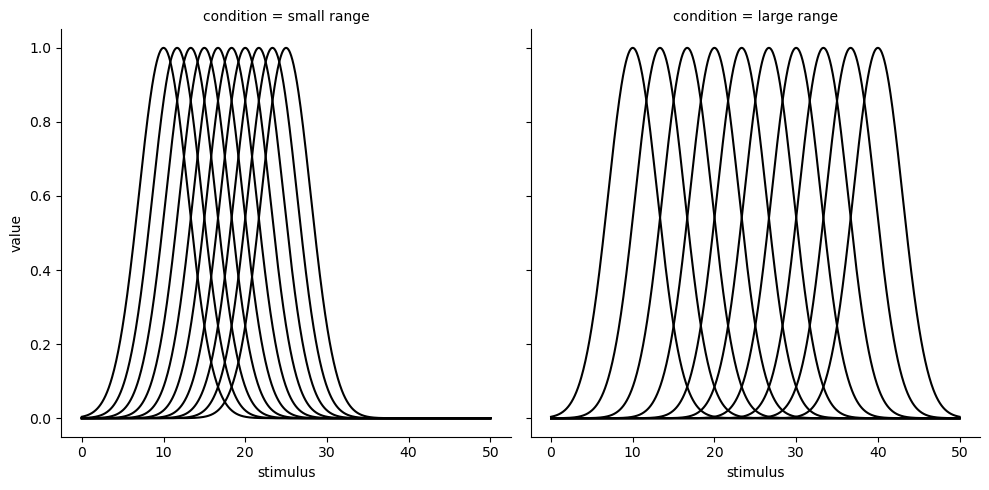

In [2]:
paradigm1 = np.arange(10, 25)
paradigm2 = np.arange(10, 40)

stimuli = np.linspace(0, 50, 1000, dtype=np.float32)

mus1 = np.linspace(10, 25, 10)
mus2 = np.linspace(10, 40, 10)


parameters1 = pd.DataFrame({'mu':mus1, 'sd':np.ones(10) * 3, 'amplitude':1.0, 'baseline':0.0, })
model1 = GaussianPRF(parameters=parameters1)

parameters2 = pd.DataFrame({'mu':mus2, 'sd':np.ones(10) * 3, 'amplitude':1.0, 'baseline':0.0, })
model2 = GaussianPRF(parameters=parameters2)


pred1 = model1.predict(paradigm=stimuli)
pred2 = model2.predict(paradigm=stimuli)
pred1.columns.name = pred2.columns.name =  'rf'

pred1.index = pd.Index(stimuli, name='stimulus')
pred2.index = pd.Index(stimuli, name='stimulus')

pred = pd.concat([pred1, pred2], keys=['small range', 'large range'], names=['condition'], axis=0)

sns.relplot(x='stimulus', y='value', col='condition', data=pred.stack().to_frame('value').reset_index(), palette=['k'], hue='rf', kind='line', legend=False)

# Result 1: Location/space between RFs changes local but not global Fisher information

Note how the the RFs on a smaller range lead to higher Fisher information for that range, but the total Fisher information remains practically the same.

(Note that the Fisher information is estimated using sampling and always has some approximation noise)

In [3]:
noise = np.identity(10).astype(np.float32)
noise2 = np.identity(10).astype(np.float32) * 1.

fisher_information1 = model1.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')
fisher_information2 = model2.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')

fisher_information = pd.concat((fisher_information1, fisher_information2), keys=['small range', 'large range'], names=['condition'], axis=0)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_17662/3718388434.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(x='stimulus', y='fisher information', col='condition', data=fisher_information.reset_index(), palette=['k'], kind='line')


,total fisher information
condition,
large range,2.876014
small range,2.991132


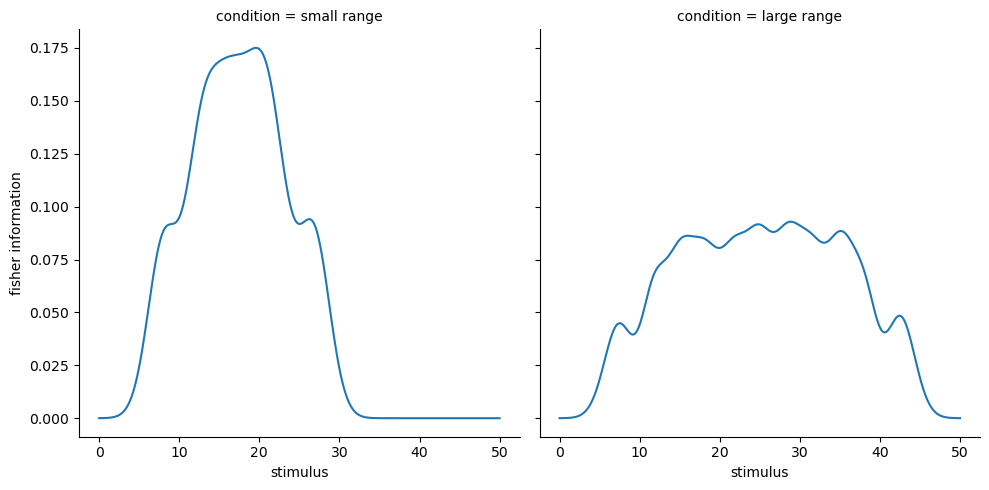

In [4]:
sns.relplot(x='stimulus', y='fisher information', col='condition', data=fisher_information.reset_index(), palette=['k'], kind='line')

fisher_information.reset_index().groupby('condition').apply(lambda x: np.trapz(x['fisher information'], x['stimulus'])).to_frame('total fisher information')

# Increasing  range of the same 10 RFs

In [5]:
from tqdm.notebook import tqdm

fi_results = []
decoding_results = []

max_range = np.arange(20, 50, 1)

for r in tqdm(max_range):
    mus = np.linspace(10, r, 10)
    parameters = pd.DataFrame({'mu':mus, 'sd':np.ones(10) * 3, 'amplitude':1.0, 'baseline':0.0, })
    model = GaussianPRF(parameters=parameters)
    fisher_information = model.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')

    fi_results.append(fisher_information)

    # Decode
    paradigm = np.repeat(np.arange(10, 50), 100)
    simulated_data = model.simulate(paradigm=paradigm, noise=noise)
    pdf = model.get_stimulus_pdf(parameters=parameters, stimulus_range=stimuli, data=simulated_data)
    E = np.trapz(pdf * stimuli, stimuli)    
    sd = np.sqrt(np.trapz(pdf * (stimuli[np.newaxis, :] - E[:, np.newaxis])**2, stimuli, axis=1))

    decoding_results.append(pd.DataFrame({'E':E, 'sd':sd}, index=pd.Index(paradigm, name='stimulus')))



fi_results = pd.concat(fi_results, keys=max_range, names=['max range'], axis=0)
decoding_results = pd.concat(decoding_results, keys=max_range, names=['max range'], axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

If we try many different ranges, indeed,
the Fisher information increases locally, but globally stays roughly the same.

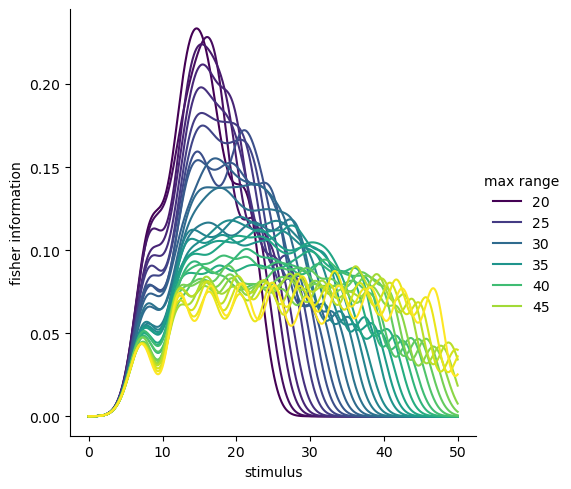

In [6]:
sns.relplot(x='stimulus', y='fisher information', hue='max range', data=fi_results.reset_index(), palette='viridis', kind='line')

## Integrated Fisher information from 0 to 50

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_17662/3410072551.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(x='max range', y='total fisher information', data=summed_fisher_information.reset_index(), palette='k', kind='line')


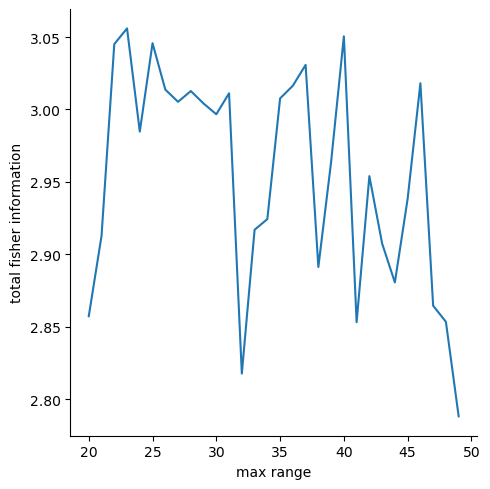

In [7]:
summed_fisher_information = fi_results.reset_index().groupby('max range').apply(lambda x: np.trapz(x['fisher information'], x['stimulus'])).to_frame('total fisher information')
sns.relplot(x='max range', y='total fisher information', data=summed_fisher_information.reset_index(), palette='k', kind='line')

If we look at **decoded uncertainty** (i.e., the s.d. of the decoded posterior), we see that the uncertainty
is lower for RFs that are closer together, but becomes much larger when stimuli fall out of the range of the RFs.

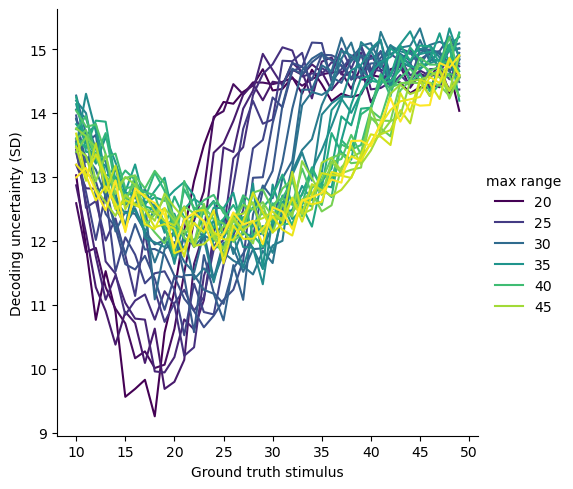

In [8]:
g =sns.relplot(x='stimulus', y='sd', hue='max range', data=decoding_results.groupby(['stimulus', 'max range']).mean().reset_index(), palette='viridis', kind='line')

g.set_xlabels('Ground truth stimulus')
g.set_ylabels('Decoding uncertainty (SD)')

There is an analogous (but subtle) effect for the **empirical error**

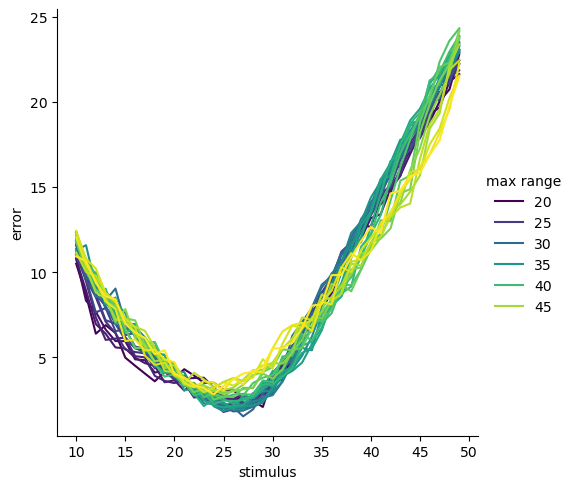

In [9]:
decoding_results['error'] = (decoding_results['E'] - decoding_results.index.get_level_values('stimulus')).abs()

sns.relplot(x='stimulus', y='error', hue='max range', data=decoding_results.groupby(['stimulus', 'max range']).mean().reset_index(), palette='viridis', kind='line')

# Result 2: Dispersion of RFs changes global Fisher information, largely independent from distance between RFs

When we change how wide the RFs are, this has a huge effect on the **global Fisher information**.

In [10]:
# Changing range _and_ dispersion of receptive fields
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product

results = []
keys = []

max_range = np.arange(20, 50, 3)
sigmas = [1, 3,  5, 10, 20]

for r, sigma in product(max_range, sigmas):
    mus = np.linspace(10, r, 10)
    parameters = pd.DataFrame({'mu':mus, 'sd':np.ones(10) * sigma, 'amplitude':1.0, 'baseline':0.0, })
    model = GaussianPRF(parameters=parameters)
    fisher_information = model.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')

    results.append(fisher_information)
    keys.append((r, sigma))

results = pd.concat(results, keys=keys, names=['max range', 'sigma'], axis=0)

  0%|          | 0/50 [00:00<?, ?it/s]

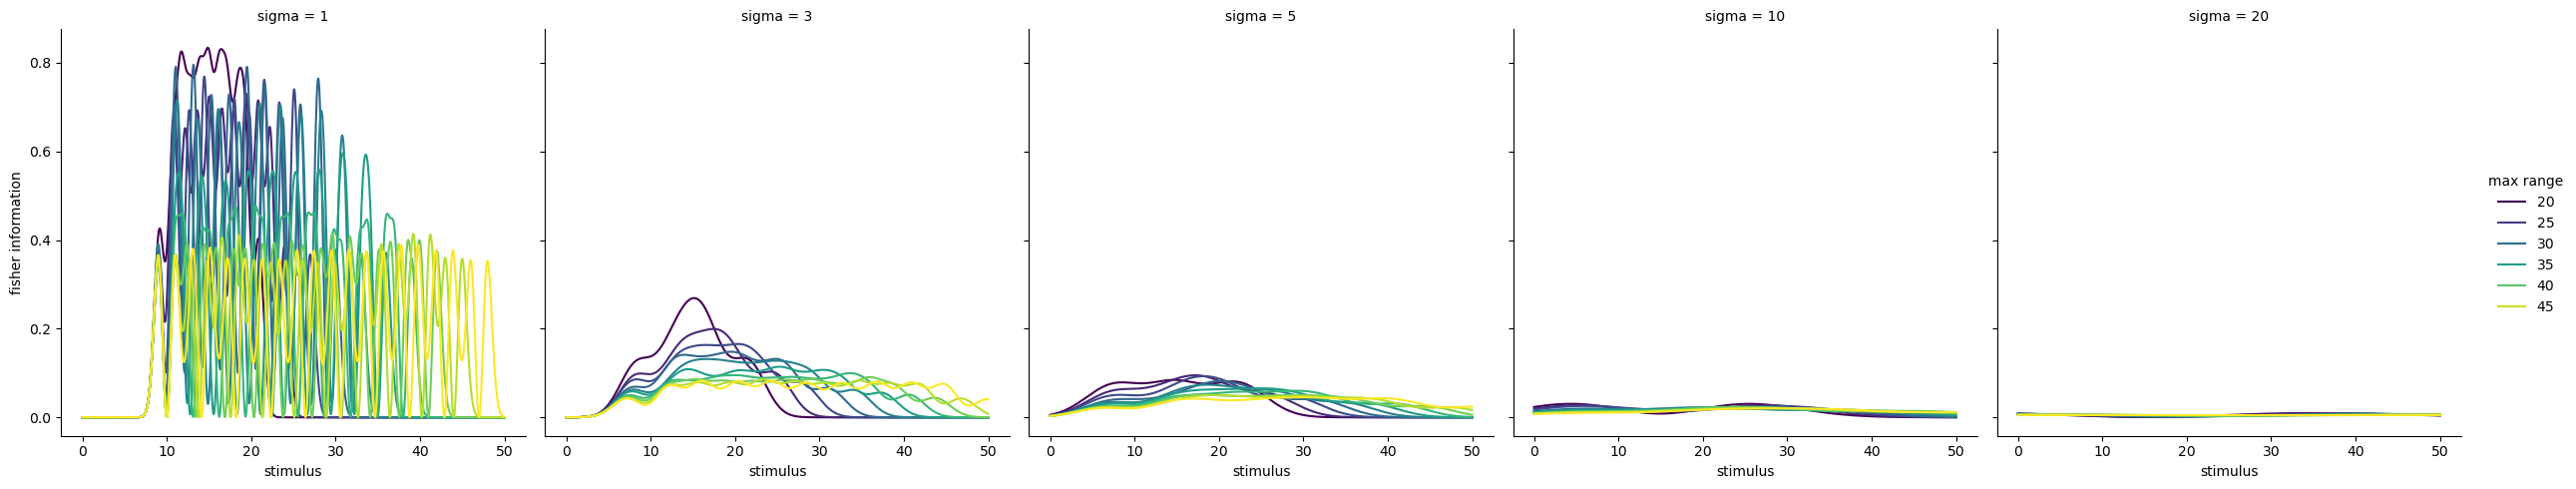

In [11]:
sns.relplot(x='stimulus', y='fisher information', hue='max range', col='sigma', data=results.reset_index(), palette='viridis', kind='line')

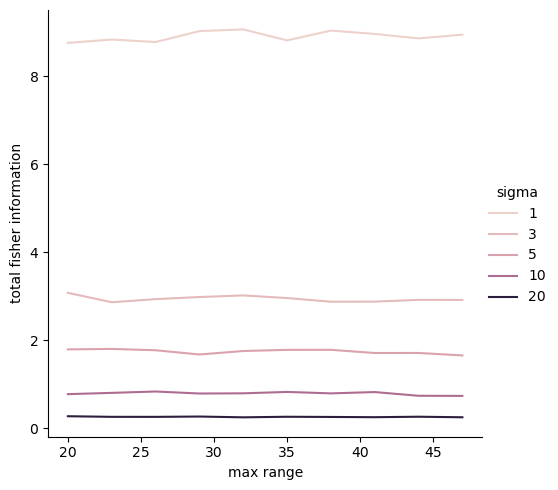

In [12]:
summed_fisher_information = results.reset_index().groupby(['max range', 'sigma']).apply(lambda x: np.trapz(x['fisher information'], x['stimulus'])).to_frame('total fisher information')
sns.relplot(x='max range', y='total fisher information', hue='sigma', data=summed_fisher_information.reset_index(), kind='line')

# Result 3: Noise effect reduces global (but not local) Fisher information

In [13]:
# Situation 2: changing range _and_ dispersion of receptive fields
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product

results = []
keys = []

max_range = np.arange(20, 50, 3, dtype=np.float32)
noises = np.array([1, 2, 3], dtype=np.float32)

for r, noise_ in product(max_range, noises):
    mus = np.linspace(10, r, 10)
    parameters = pd.DataFrame({'mu':mus, 'sd':np.ones(10) * 3., 'amplitude':1.0, 'baseline':0.0, })
    model = GaussianPRF(parameters=parameters)

    noise = np.identity(10).astype(np.float32) * noise_
    fisher_information = model.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')

    results.append(fisher_information)
    keys.append((r, noise_))

results = pd.concat(results, keys=keys, names=['max range', 'noise'], axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

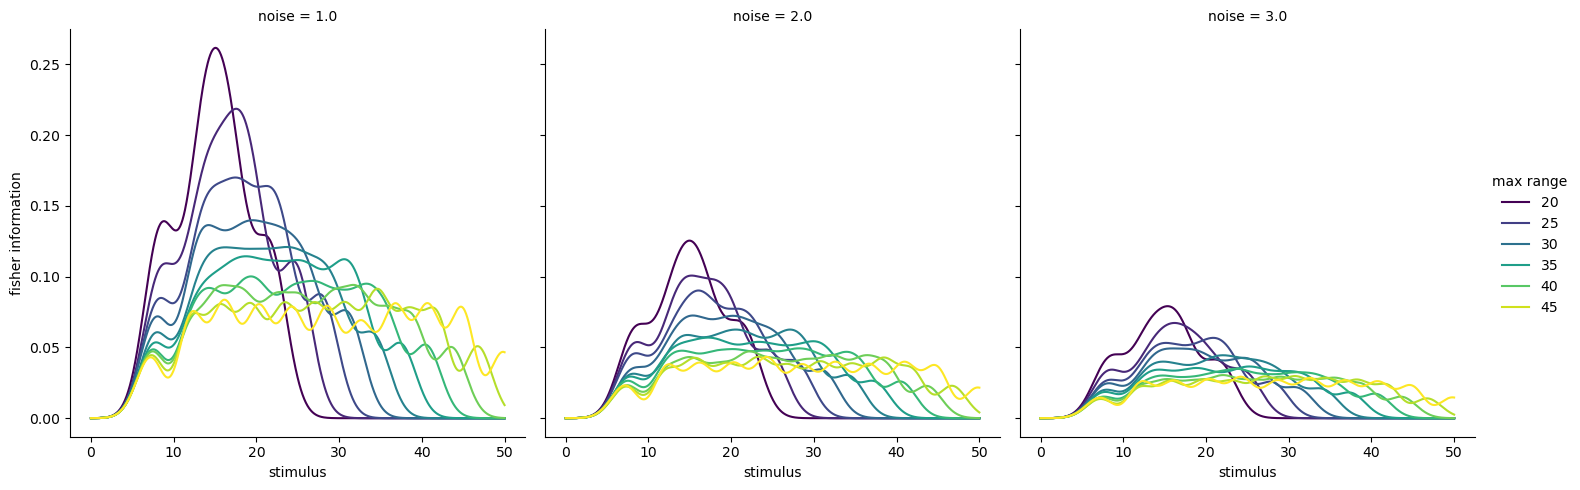

In [14]:
sns.relplot(x='stimulus', y='fisher information', hue='max range', col='noise', data=results.reset_index(), palette='viridis', kind='line')

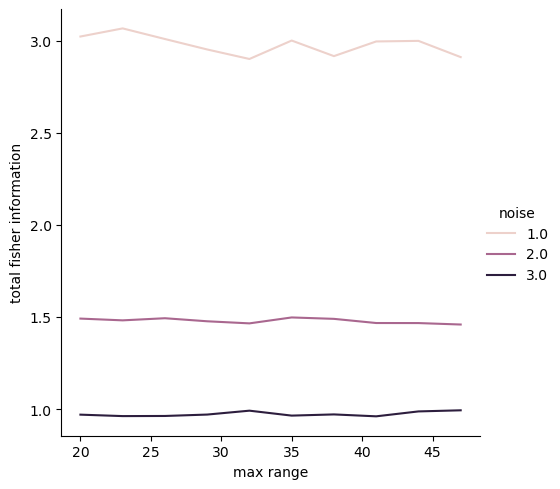

In [15]:
summed_fisher_information = results.reset_index().groupby(['max range', 'noise']).apply(lambda x: np.trapz(x['fisher information'], x['stimulus'])).to_frame('total fisher information')
sns.relplot(x='max range', y='total fisher information', hue='noise', data=summed_fisher_information.reset_index(), kind='line')

# Result 4: 'real' Fisher information based on estimated (rather than ground truth) parameters gives similar results

In [17]:
# Situation 2: changing range _and_ dispersion of receptive fields
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product

from braincoder.optimize import ParameterFitter, ResidualFitter

results = []
keys = []

max_range = np.arange(20, 50, 10, dtype=np.float32)
noises = np.array([1, 2], dtype=np.float32)

for r, noise_ in product(max_range, noises):
    mus = np.linspace(10, r, 10)
    parameters = pd.DataFrame({'mu':mus, 'sd':np.ones(10) * 3., 'amplitude':1.0, 'baseline':0.0, })
    model = GaussianPRF(parameters=parameters)

    noise = np.identity(10).astype(np.float32) * noise_
    fisher_information = model.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')

    paradigm = np.random.randint(10, r+1, 200)

    simulated_data = model.simulate(paradigm=paradigm, noise=noise)

    parameter_fitter = ParameterFitter(model=model, paradigm=paradigm, data=simulated_data)

    mu_ = np.linspace(10, 50, 10)
    sd_ = np.linspace(.5, 5, 10)
    amplitude = [1.]
    baseline = [0.]

    grid_pars = parameter_fitter.fit_grid(mu_, sd_, amplitude, baseline, use_correlation_cost=True)
    gd_pars = parameter_fitter.fit(init_pars=grid_pars)

    residual_fitter = ResidualFitter(model=model, paradigm=paradigm, data=simulated_data)
    model.init_pseudoWWT(stimulus_range=np.linspace(10, 50), parameters=gd_pars)
    omega, dof = residual_fitter.fit()

    estimated_fisher_information = model.get_fisher_information(stimuli=stimuli, omega=omega, n=1000).to_frame('fisher information')
    real_fisher_information = model.get_fisher_information(stimuli=stimuli, omega=noise, n=1000).to_frame('fisher information')
    
    fisher_information = pd.concat((estimated_fisher_information, real_fisher_information), keys=['estimated', 'ground truth'], names=['estimation'], axis=0)

    results.append(fisher_information)
    keys.append((r, noise_))

results = pd.concat(results, keys=keys, names=['max range', 'noise'], axis=0)

  0%|          | 0/6 [00:00<?, ?it/s]

Working with chunk size of 333333
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|          | 0/1000 [00:00<?, ?it/s]

init_tau: 0.9434981346130371, 1.0194904804229736
USING A PSEUDO-WWT!
WWT max: 34.076690673828125


  0%|          | 0/1000 [00:00<?, ?it/s]

Working with chunk size of 333333
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|          | 0/1000 [00:00<?, ?it/s]

init_tau: 1.3404664993286133, 1.5343891382217407
USING A PSEUDO-WWT!
WWT max: 23.138792037963867


  0%|          | 0/1000 [00:00<?, ?it/s]

Working with chunk size of 333333
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|          | 0/1000 [00:00<?, ?it/s]

init_tau: 0.9710736870765686, 1.0774637460708618
USING A PSEUDO-WWT!
WWT max: 13.619714736938477


  0%|          | 0/1000 [00:00<?, ?it/s]

Working with chunk size of 333333
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|          | 0/1000 [00:00<?, ?it/s]

init_tau: 1.3441139459609985, 1.4571908712387085
USING A PSEUDO-WWT!
WWT max: 13.108214378356934


  0%|          | 0/1000 [00:00<?, ?it/s]

Working with chunk size of 333333
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|          | 0/1000 [00:00<?, ?it/s]

init_tau: 0.9141477346420288, 1.0709460973739624
USING A PSEUDO-WWT!
WWT max: 11.226747512817383


  0%|          | 0/1000 [00:00<?, ?it/s]

Working with chunk size of 333333
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|          | 0/1000 [00:00<?, ?it/s]

init_tau: 1.3507893085479736, 1.4824072122573853
USING A PSEUDO-WWT!
WWT max: 15.250056266784668


  0%|          | 0/1000 [00:00<?, ?it/s]

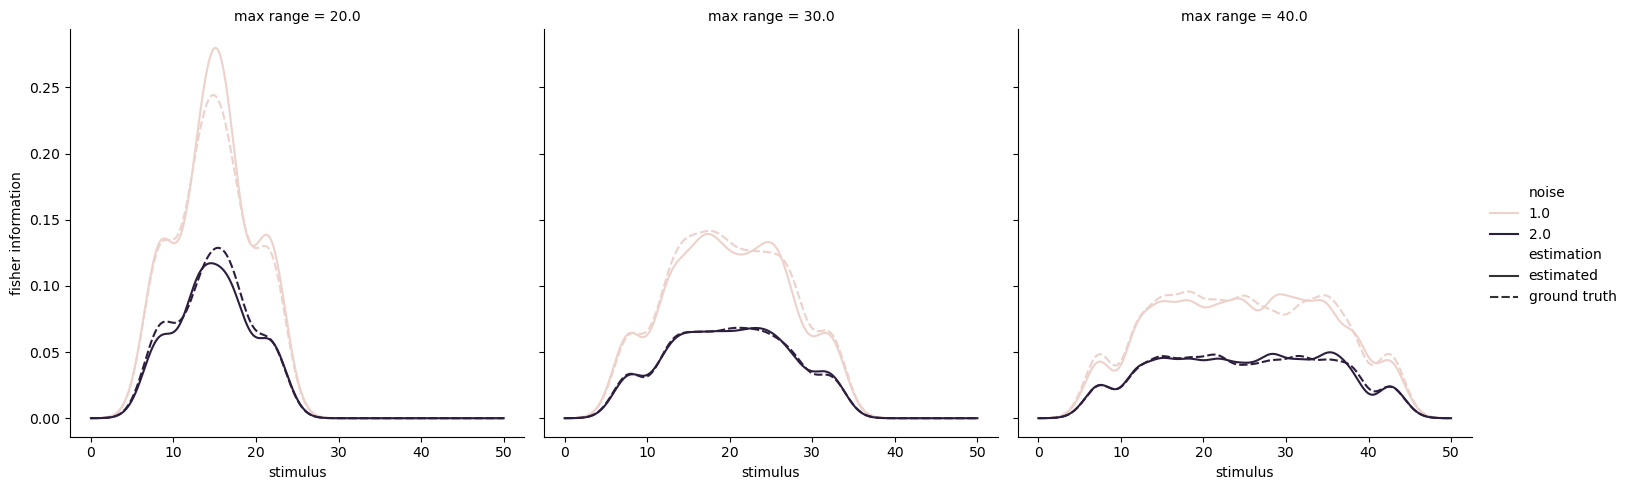

In [18]:
g = sns.relplot(x='stimulus', y='fisher information', style='estimation', col='max range', hue='noise', col_wrap=3, data=results.reset_index(), kind='line')

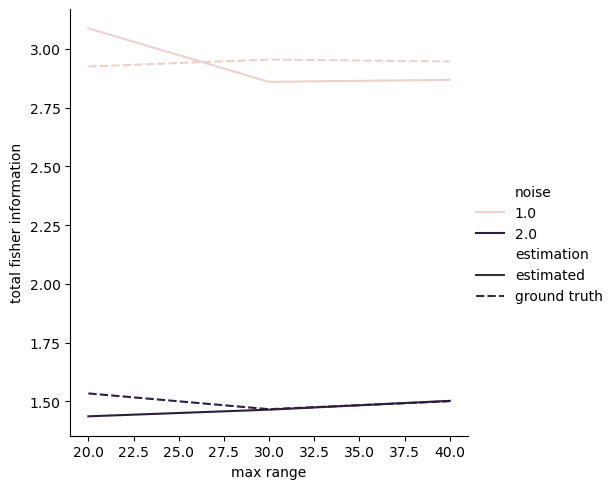

In [19]:
summed_fisher_information = results.reset_index().groupby(['max range', 'noise', 'estimation']).apply(lambda x: np.trapz(x['fisher information'], x['stimulus'])).to_frame('total fisher information')

g = sns.relplot(x='max range', y='total fisher information', hue='noise', style='estimation', data=summed_fisher_information.reset_index(), kind='line')